# R68 MCMC

Use MCMC to estimate yield model parameters for R68 data

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#Set up notebook and load some R68 constants (V, eps, etc.)
exec(open("nb_setup.py").read())#Is there a better way to do this?
from constants import *

../mplstyles
3.1.1
/data/chocula/mast/cdms/analysis/run068/R68_paper2019/mplstyles


In [3]:
#Load the data
import R68_load as r68

meas=r68.load_measured()
g4=r68.load_G4()
cap=r68.load_simcap()

Loading Measured Data...
(480634,)
(174510,)
Loading Geant4 Data...
(528848, 7)
(129555, 7)
Loading NRs...
1.2  min
Loading ERs...
0.3  min
Loading (n,gamma) Data...
200000


In [4]:
#Energy binning
Emax = 2000 #eVee
Ebins=np.linspace(0,Emax,201)
Ebin_ctr=(Ebins[:-1]+Ebins[1:])/2

#Measured spectra
N_meas_PuBe,_ = np.histogram(meas['PuBe']['E'],bins=Ebins)
N_meas_Bkg,_ = np.histogram(meas['Bkg']['E'],bins=Ebins)

tlive_PuBe = meas['PuBe']['tlive']
tlive_Bkg = meas['Bkg']['tlive']
#We'll scale everything to the PuBe live time and work with counts, not rate, to get the Poisson stats right

N_meas_Bkg_scaled = N_meas_Bkg * tlive_PuBe/tlive_Bkg

#Estimate of counts due to PuBe
N_meas = N_meas_PuBe - N_meas_Bkg_scaled

In [5]:
#Import yield models
import R68_yield as Yield
import R68_spec_tools as spec

dict_keys(['xx', 'yy', 'ex', 'ey'])


/home/mast/python/miniconda3/envs/nr_fano/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/mast/python/miniconda3/envs/nr_fano/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [6]:
Y=Yield.Yield('Lind',[0.15])
print(Y.models)

['Lind: Lindhard', 'Chav: Chavarria', 'Sor: Sorenson', 'Damic: Extrapolated Damic model']


In [137]:
#Define likelihood functions
from scipy.special import factorial, gamma, loggamma

#Poisson likelihood of measuring k given expected mean of lambda
def pois_likelihood(k, lamb):
    return (lamb**k)*np.exp(-lamb)/gamma(k+1.)

#Poisson log-likelihood
#k: observed counts
#lamb: expected (model) counts
def ll_pois(k, lamb):   
    if np.sum(lamb<=0):
        return -np.inf
    
    return np.sum(k*np.log(lamb) - lamb - loggamma(k+1.))

#Normal log-likelihood, limit of Poisson for large lambda
#k: observed counts
#lamb: expected (model) counts
def ll_norm(k,lamb):
    if np.sum(lamb<=0):
        return -np.inf
    
    return np.sum(-0.5*np.log(2*np.pi*lamb) - (k-lamb)**2/(2*lamb))

In [66]:
#Log of flat prior functions
#theta: array of parameter values
#bounds: array of parameter bounds. shape should be len(theta)x2
def lp_flat(theta, bounds):
    #for itheta,ibounds in zip(theta,bounds):
    #    if not (ibounds[0] < itheta < ibounds[1]):
    #        return -np.inf
        
    #return 0.0
    
    if (np.array(theta_bounds)[:,0]<theta).all() and (theta<np.array(theta_bounds)[:,1]).all():
        return 0.0
    return -np.inf

In [75]:
#Calculate Log probability, log(likelihood*prior)
#
#model: pre-defined Yield model
#theta: array of fit parameters (yield, F_NR, etc.)
#theta_bounds: paramter bounds, shape should be len(theta)x2
#spec_bounds: range of bin numbers in spectrum to consider. The analysis range is [bin_low,bin_high)
#likelihood: Likelihood function, either 'Pois' or 'Norm'

def calc_log_prob(model='Lind',theta=[0.2, 1.5, 2.4], theta_bounds=((0,1),(0,10),(0,5)), spec_bounds=(5,101), likelihood='Norm'):

    #Access the global data we loaded
    global N_meas, tlive_PuBe, g4, cap, Y
    
    ############
    #Set some local variables
    F_NR=None
    scale_g4=None
    scale_ng=None
    NR=None
    ER=None
    NG=None
    
    if model=='Lind':
        #Lindhard
        Y.model=model
        Y.pars=theta[:1]
        F_NR=theta[2]
        scale_g4=theta[1]
        scale_ng=scale_g4

    elif (model=='Chav' or model=='Sor'):
        #Chavarria or Sorensen with constant
        Y.model=model
        Y.pars=theta[:2]
        F_NR=theta[3]
        scale_g4=theta[2]
        scale_ng=scale_g4

    elif (model=='Damic'):
        #Damic yield
        Y.model=model
        Y.pars=[]
        F_NR=theta[1]
        scale_g4=theta[0]
        scale_ng=scale_g4

    else:
        print('Error: Yield model not defined.')
        return None
    
    
    #Calculate the (log)prior first since we may not need to calculate the likelihood
    lp=lp_flat(theta, theta_bounds)
    if not np.isfinite(lp):
        return -np.inf
        
    
    ##########
    #Build the spectra
    #NR,ER,NG=spec.buildSimSpectra_ee(Ebins=Ebins, Evec_nr=g4['NR']['E'], Evec_er=g4['ER']['E'], Evec_ng=cap['E'], dEvec_ng=cap['dE'], 
                                         #Yield=Y, F_NR=F_NR, scale_g4=scale_g4, scale_ng=scale_ng, doDetRes=True, seed=1)

    #Avg spectra is more stable
    NR,ER,NG=spec.buildAvgSimSpectra_ee(Ebins=Ebins, Evec_nr=g4['NR']['E'], Evec_er=g4['ER']['E'], Evec_ng=cap['E'], dEvec_ng=cap['dE'],
                                        Yield=Y, F_NR=F_NR, scale_g4=scale_g4, scale_ng=scale_ng, doDetRes=True)


    #Total counts for PuBe live time
    #Uncertainty will be sqrt(N)
    N_pred = (NR/g4['NR']['tlive'] + ER/g4['ER']['tlive'] + NG/cap['tlive'])*tlive_PuBe

    ##########
    #Calculate the log probability = log prior + log likelihood
    ll=None
    
    if likelihood=='Norm':
        ll = ll_norm(N_meas[slice(*spec_bounds)],N_pred[slice(*spec_bounds)])
    elif likelihood=='Pois':
        ll = ll_pois(N_meas[slice(*spec_bounds)],N_pred[slice(*spec_bounds)])
    else:
        print('Error: Bad likelihood')
        return None
    
    if not np.isfinite(ll):
        return -np.inf
    
    return lp + ll

# Lindhard Fit

In [117]:
import emcee
from multiprocessing import Pool

#Lindhard fit
# theta = k, sim_scale, F_NR
labels_l = ['k', 'sim scale', 'F_{NR}']

Y=Yield.Yield('Lind',[0.2])

#Wrapper help
def LindFit_helper(theta):
    return calc_log_prob(model='Lind', theta=theta, theta_bounds=((0,1),(0,10),(0,5)),
                         spec_bounds=(5,101), likelihood='Pois')

In [146]:
nwalkers_l = 8
ndim_l = 3
nstep_l=5000
guesses_l = np.array([0.18, 1.6, 3.8]) + 1e-3 * np.random.randn(nwalkers_l, ndim_l)

with Pool(processes=20) as pool: #Can fail depending on current memory usage of other processes...
    sampler_l = emcee.EnsembleSampler(nwalkers_l, ndim_l, LindFit_helper, pool=pool)
    sampler_l.run_mcmc(guesses_l, nstep_l, progress=True);

100%|██████████| 5000/5000 [41:47:13<00:00, 30.09s/it]   


In [147]:
#Save this work
import pickle as pkl
import os

saveMCMC=True

if saveMCMC:
    ifile = 0
    fname='data/mcmc_Lind_{0}walk_{1}step_pois_v{2}.pkl'.format(nwalkers_l,nstep_l,ifile+1)
    while os.path.exists(fname):
        ifile += 1
        fname='data/mcmc_Lind_{0}walk_{1}step_pois_v{2}.pkl'.format(nwalkers_l,nstep_l,ifile+1)
        
    print(fname)
    saveFile = open(fname, 'wb')
    pkl.dump(sampler_l,saveFile)
    pkl.dump(guesses_l,saveFile)
    saveFile.close()

data/mcmc_Lind_8walk_5000step_pois_v1.pkl


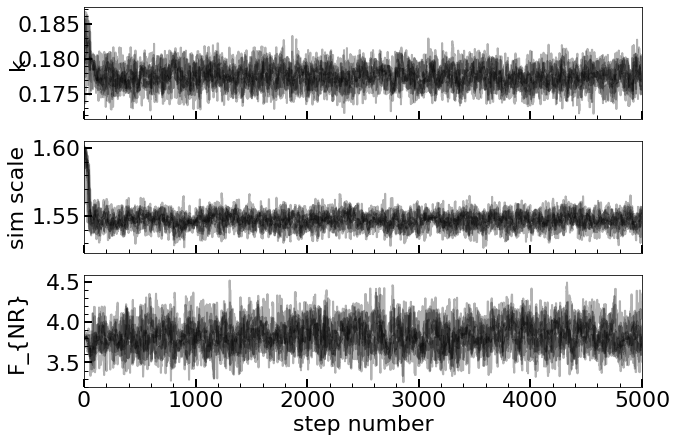

In [148]:
#Look at the chain of parameter values
fig, axes = plt.subplots(ndim_l, figsize=(10, 7), sharex=True)
samples_l = sampler_l.get_chain()
for i in range(ndim_l):
    ax = axes[i]
    ax.plot(samples_l[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_l))
    #ax.set_ylim(0, 5)
    ax.set_ylabel(labels_l[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [149]:
#Get the sample autocorrelation time
tau_l=sampler_l.get_autocorr_time()
print(tau_l)
avgtau_l=round(np.average(tau_l))
print(avgtau_l)

[42.73063231 43.67642262 46.96358875]
44.0


In [150]:
#Discard a few times tau as burn-in and thin by tau/2
avgtau_l=90
flat_samples_l = sampler_l.get_chain(discard=int(2.*avgtau_l), thin=int(round(avgtau_l/2.)), flat=True)
#flat_samples_l = sampler.get_chain(discard=40, flat=True)
print(flat_samples_l.shape)

(856, 3)


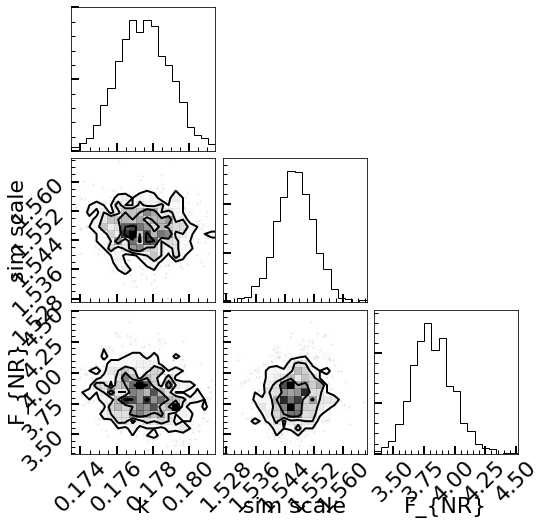

In [151]:
import corner

fig = corner.corner(
    flat_samples_l, labels=labels_l
);

In [152]:
from IPython.display import display, Math

for i in range(ndim_l):
    mcmc = np.percentile(flat_samples_l[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels_l[i])
    display(Math(txt))

<>:6: DeprecationWarning: invalid escape sequence \m
<>:6: DeprecationWarning: invalid escape sequence \m
<>:6: DeprecationWarning: invalid escape sequence \m
<ipython-input-152-cdf74877f44d>:6: DeprecationWarning: invalid escape sequence \m
  txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [102]:
print(flat_samples_l[0])

[0.17653799 1.54957441 3.84206782]


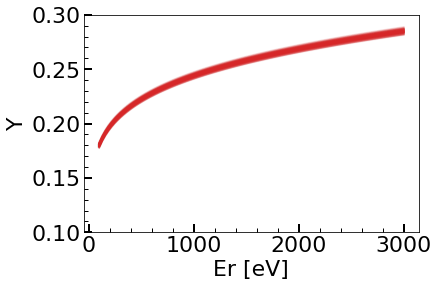

In [115]:
#Plot best fit yield
fig, ax = plt.subplots(1,1)

Er_plot=np.linspace(100,3e3,100)

inds = np.random.randint(len(flat_samples_l), size=100)
for ind in inds:
    thetai = flat_samples_l[ind][0]
    Y=Yield.Yield('Lind',[thetai])
    plt.plot(Er_plot, Y.calc(Er_plot), "C3", alpha=0.1)

ax.set_xlabel('Er [eV]')
ax.set_ylabel('Y')
ax.set_ylim(0.1,0.3);

#plt.legend()

# Chavarria Fit

In [116]:
#Chavarria fit
# theta = k, a, sim_scale, F_NR
labels_c = ['k', 'a', 'sim scale', 'F_{NR}']

Y=Yield.Yield('Chav',[0.19, 1.58])

#Wrapper help
def ChavFit_helper(theta):
    return calc_log_prob(model='Chav', theta=theta, theta_bounds=((0,1),(1./1000,1./0.1),(0,10),(0,5)),
                         spec_bounds=(5,101), likelihood='Norm')